Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6684 - loss: 1.8492 - val_accuracy: 0.9753 - val_loss: 0.0939
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9456 - loss: 0.1828 - val_accuracy: 0.9887 - val_loss: 0.0448
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9592 - loss: 0.1376 - val_accuracy: 0.9887 - val_loss: 0.0438
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9673 - loss: 0.1022 - val_accuracy: 0.9907 - val_loss: 0.0364
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9678 - loss: 0.0986 - val_accuracy: 0.9920 - val_loss: 0.0320
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9650 - loss: 0.1032 - val_accuracy: 0.9853 - val_loss: 0.0432
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9704 - loss: 0.0877 - val_accuracy: 0.9907 - val_loss: 0.0304
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9759 - loss: 0.0766 - val_accuracy: 0

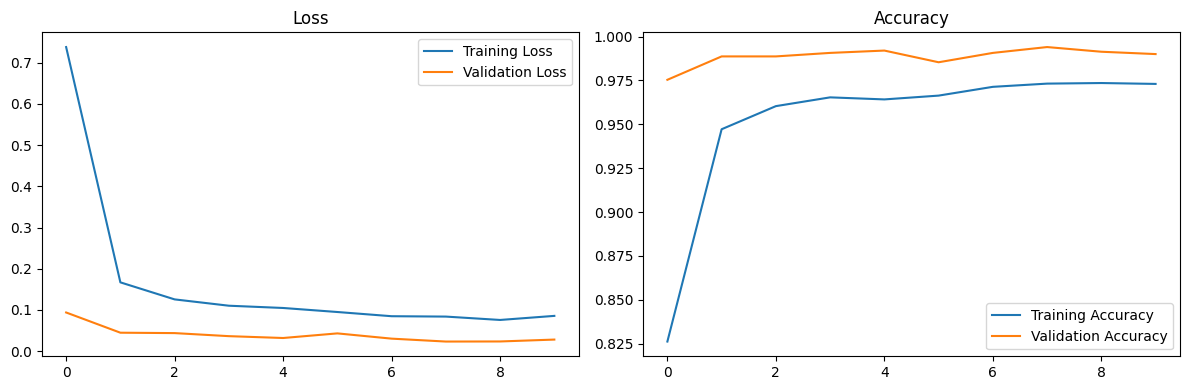

In [4]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, Dropout, Input
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Function to extract MFCC features
def extract_mfcc(file_path, n_mfcc=13):
    audio, sample_rate = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
    mfccs_mean = np.mean(mfccs.T, axis=0)
    return mfccs_mean

# Process dataset and extract MFCC features
def process_dataset(directory_path):
    mfcc_features = []
    labels = []
    
    for speaker in os.listdir(directory_path):
        speaker_path = os.path.join(directory_path, speaker)
        if not os.path.isdir(speaker_path) or speaker.startswith('_'):
            continue
        
        for file_name in os.listdir(speaker_path):
            if file_name.endswith('.wav'):
                file_path = os.path.join(speaker_path, file_name)
                mfcc = extract_mfcc(file_path)
                mfcc_features.append(mfcc)
                labels.append(speaker)
    
    df = pd.DataFrame(mfcc_features)
    df['label'] = labels
    return df

# Dataset path
dataset_path = "16000_pcm_speeches"

# Process dataset and encode labels
df = process_dataset(dataset_path)
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

# Save label classes for later
np.save('label_encoder_classes.npy', label_encoder.classes_)

# Split data into train and test sets
X = df.drop('label', axis=1)
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape data for CNN input
X_train_cnn = X_train.values.reshape(X_train.shape[0], 13, 1)
X_test_cnn = X_test.values.reshape(X_test.shape[0], 13, 1)

# Save test data for later
np.save("X_test_cnn.npy", X_test_cnn)
np.save("y_test.npy", y_test)

# Convert labels to categorical format
total_classes = len(label_encoder.classes_)
y_train_categorical = to_categorical(y_train, num_classes=total_classes)
y_test_categorical = to_categorical(y_test, num_classes=total_classes)

# Build CNN model
def build_cnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Train and save model
cnn_model = build_cnn_model((13, 1), total_classes)
history = cnn_model.fit(X_train_cnn, y_train_categorical, epochs=10, batch_size=32, validation_data=(X_test_cnn, y_test_categorical))
cnn_model.save("cnn_model.keras")  # Save model in .keras format

# Evaluate the model
loss, accuracy = cnn_model.evaluate(X_test_cnn, y_test_categorical)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_title('Loss')
axes[0].legend()

axes[1].plot(history.history['accuracy'], label='Training Accuracy')
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_title('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()
